In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import joblib

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

e:\AI\Setup\Anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path ='./liver_cirrhosis.csv'
def load_data(file_path):
    return pd.read_csv(file_path)

df =load_data(file_path)
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [3]:
data=df.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [5]:
pd.DataFrame(data.isna().sum()).T.style.background_gradient(cmap='rainbow')

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
data.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,1887.117040,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


In [7]:
# data = data.drop_duplicates()


In [8]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

In [9]:
target = 'Stage'

cont_cols = data.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = data.select_dtypes(object).columns

len(cont_cols), len(obj_cols)

(11, 7)

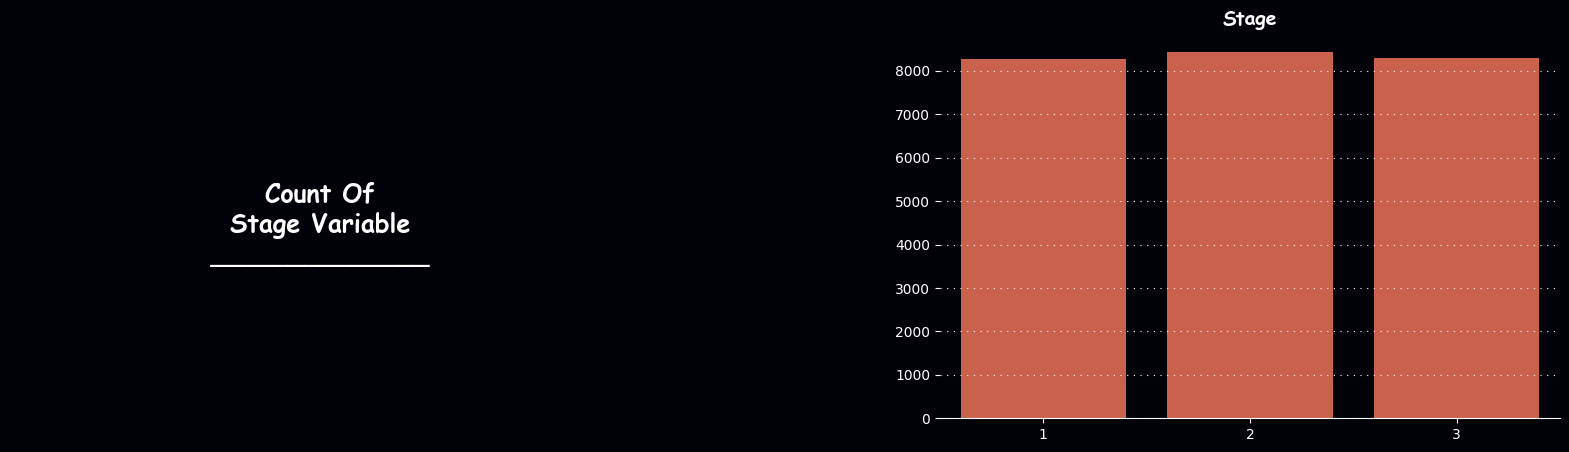

In [10]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nStage Variable\n______________')

sns.countplot(x=data[target], ax = axes[1], color=palette[0])
cb(axes[1])

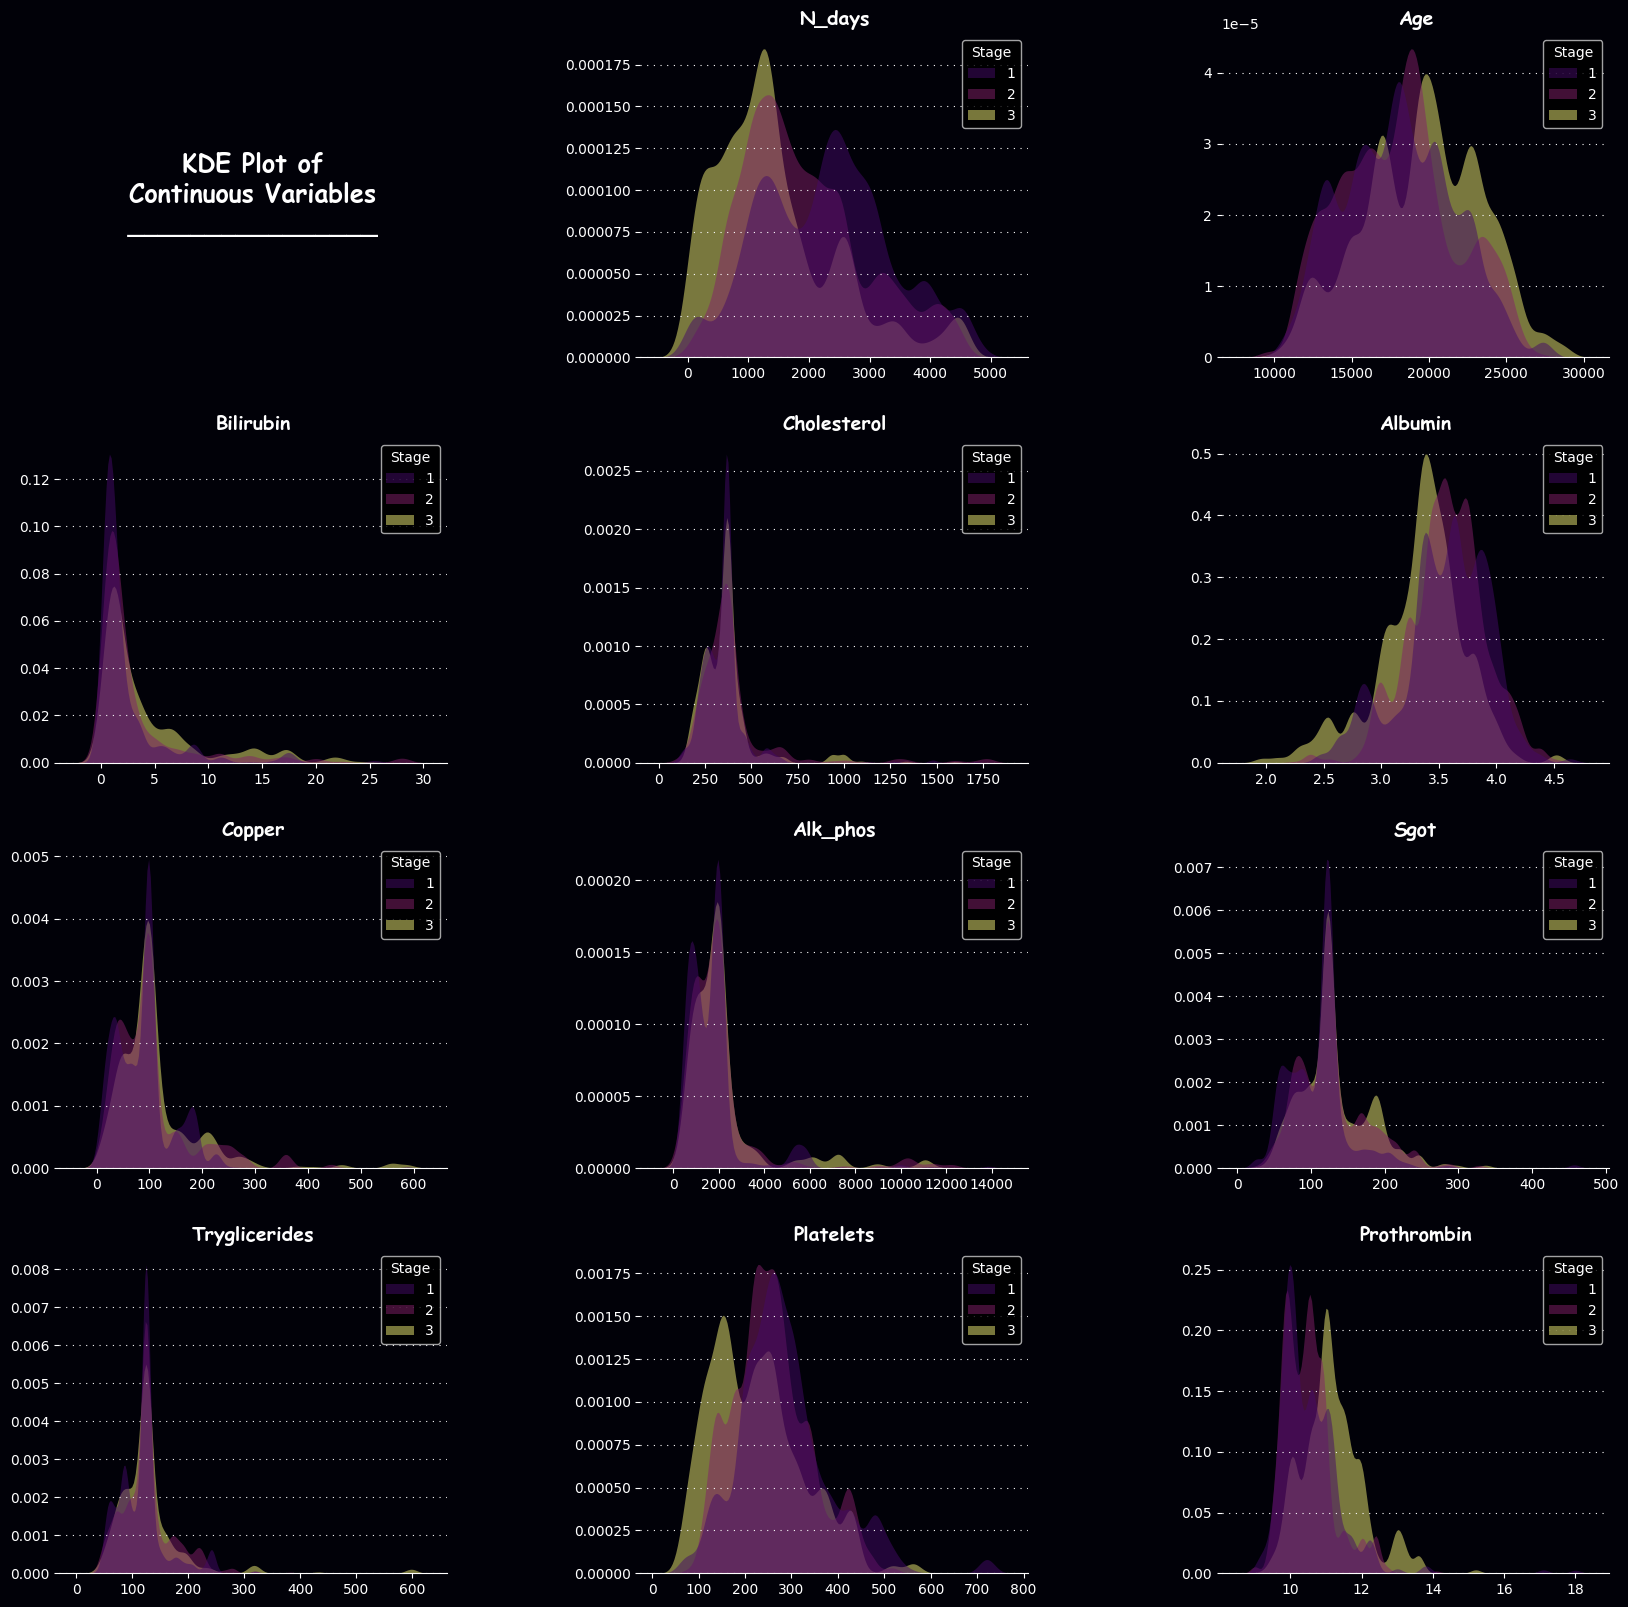

In [11]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=data, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

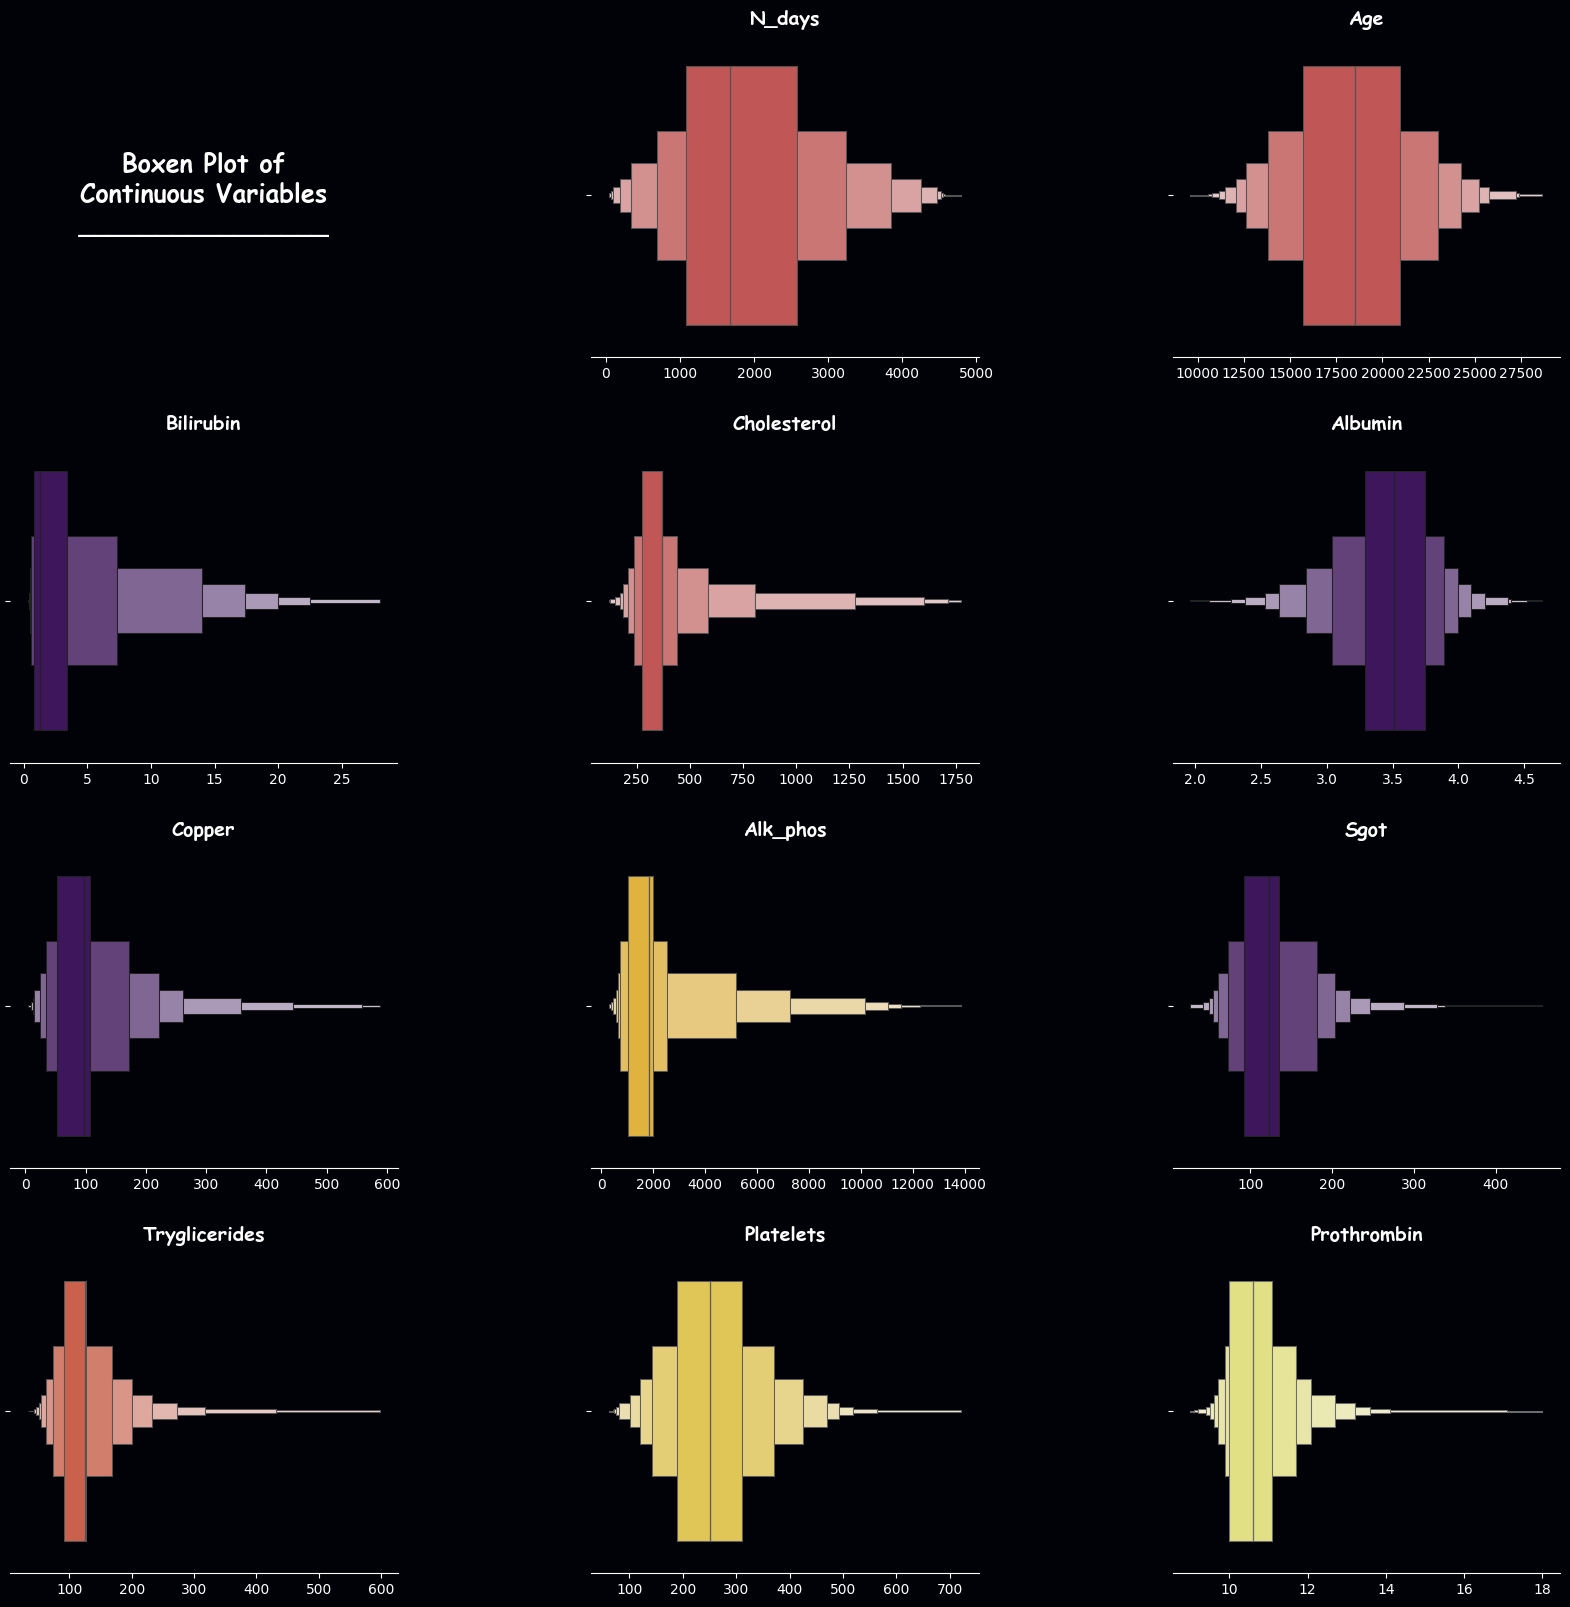

In [12]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=data, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_9896\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_9896\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_9896\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_9896\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce 

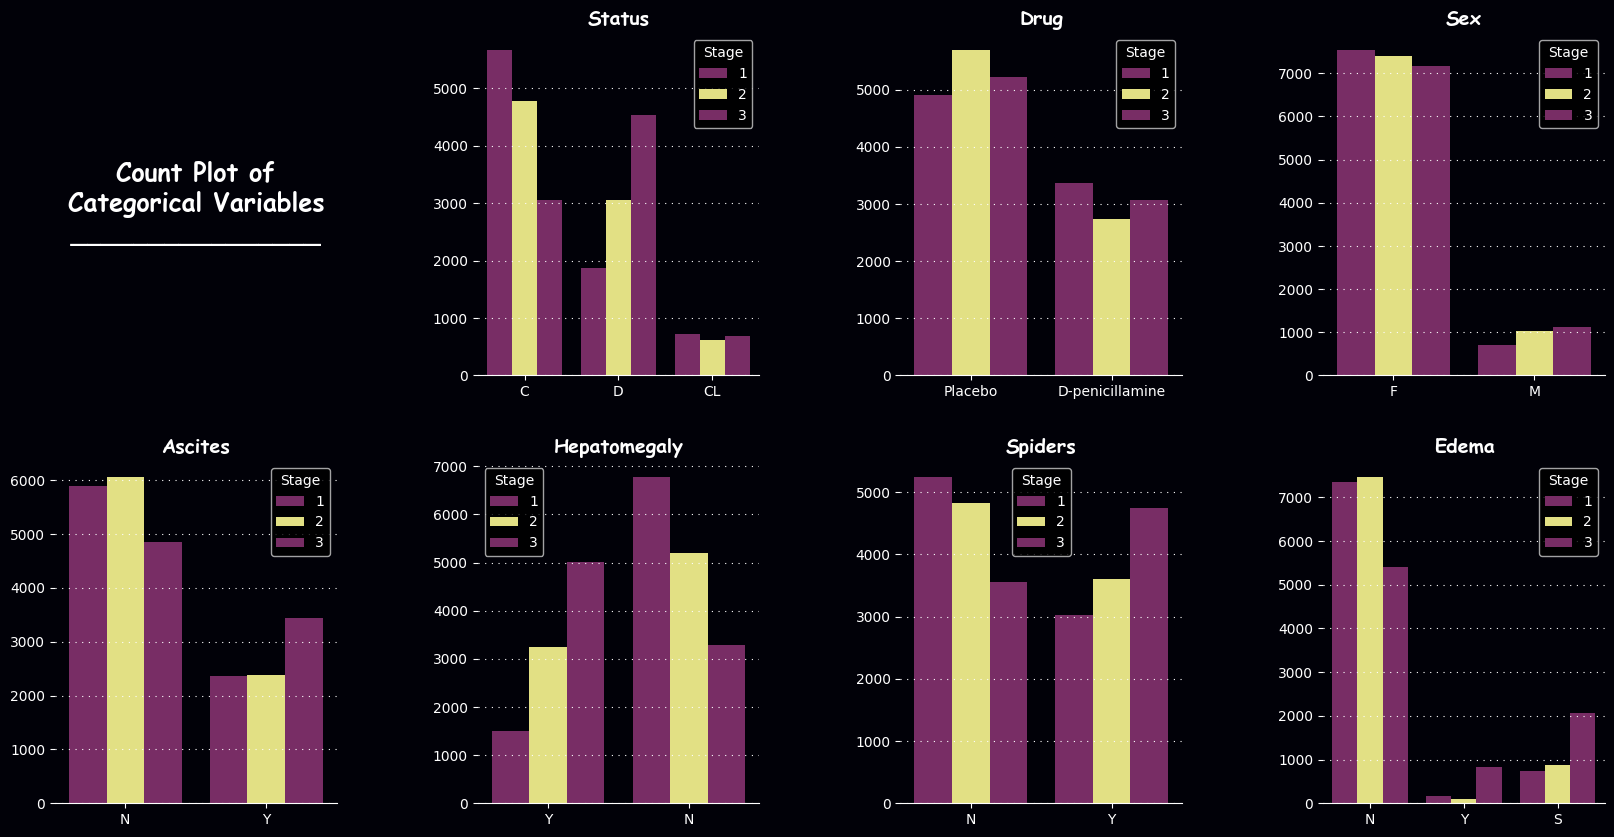

In [13]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

In [14]:
# data = data.drop_duplicates()


In [15]:
# data.drop(['Sex','Drug','Spiders','Ascites','Status','Edema'],axis=1,inplace=True) 

In [16]:
for col in data.select_dtypes(object):
    data[col] = LabelEncoder().fit_transform(data[col])
    
data

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,0,1,18499,0,0,1,0,0,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,0,1,19724,1,1,0,1,0,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,0,1,11839,0,0,0,0,0,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,2,1,16467,0,0,0,0,0,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,2,1,21699,0,0,1,0,0,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,2,0,16736,0,0,1,1,2,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,0,0,16990,0,0,1,0,0,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


In [17]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:, -1], random_state=3, train_size=.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17500, 18), (17500,), (7500, 18), (7500,))

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)


In [19]:
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

In [20]:
svm = SVC(kernel='rbf', random_state=42)   
svm.fit(x_train, y_train_enc)
y_pred_svm = svm.predict(x_test)

print("SVM Report:")
print(classification_report(y_test_enc, y_pred_svm))
print("Accuracy:", accuracy_score(y_test_enc, y_pred_svm))

SVM Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      2500
           1       0.69      0.67      0.68      2505
           2       0.81      0.79      0.80      2495

    accuracy                           0.74      7500
   macro avg       0.74      0.74      0.74      7500
weighted avg       0.74      0.74      0.74      7500

Accuracy: 0.7368


In [21]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(x_train, y_train_enc)
y_pred_lr = lr.predict(x_test)

print("Logistic Regression Report:")
print(classification_report(y_test_enc, y_pred_lr))
print("Accuracy:", accuracy_score(y_test_enc, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.58      2500
           1       0.51      0.47      0.49      2505
           2       0.65      0.68      0.67      2495

    accuracy                           0.58      7500
   macro avg       0.58      0.58      0.58      7500
weighted avg       0.58      0.58      0.58      7500

Accuracy: 0.5790666666666666


In [22]:


dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train_enc)   

y_pred_dt = dt.predict(x_test)

print("Decision Tree Report:")
print(classification_report(y_test_enc, y_pred_dt))
print("Accuracy:", accuracy_score(y_test_enc, y_pred_dt))


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2500
           1       0.90      0.91      0.90      2505
           2       0.93      0.93      0.93      2495

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500

Accuracy: 0.9166666666666666


In [23]:

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train_enc)  
y_pred_rf = rf.predict(x_test)

print("Random Forest Report:")
print(classification_report(y_test_enc, y_pred_rf))
print("Accuracy:", accuracy_score(y_test_enc, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2500
           1       0.94      0.95      0.94      2505
           2       0.96      0.97      0.96      2495

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500

Accuracy: 0.9528


In [24]:
xg = XGBClassifier()
xg.fit(x_train, y_train_enc)   
y_pred_xg = xg.predict(x_test)
print(classification_report(y_test_enc, y_pred_xg))  


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2500
           1       0.94      0.96      0.95      2505
           2       0.97      0.97      0.97      2495

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500



In [25]:
joblib.dump(xg, "xgb_model.pkl")

loaded_model = joblib.load("xgb_model.pkl")

In [26]:
voting_classifier = VotingClassifier(
    estimators=[('cat', CatBoostClassifier(verbose=0)), ('xg', XGBClassifier()), ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)

voting_classifier.fit(x_train, y_train)

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x000002B4FB974980>),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm', LGBMClassifier(verbose=-1))],
                 voting='soft')

In [27]:
y_pred = voting_classifier.predict(x_test)

C:\Users\Hany Mostafa\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:

print (classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      2467
           2       0.96      0.95      0.95      2547
           3       0.97      0.97      0.97      2486

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500

